<a href="https://colab.research.google.com/github/renanluizc/machine_learning_course/blob/main/ml_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import zipfile
import requests
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 2
LEARNING_RATE = 0.0001

os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

In [4]:
def load_and_preprocess_data():
    print("Carregando dataset cats_vs_dogs...")

    (ds_train, ds_test), info = tfds.load(
        'cats_vs_dogs',
        split=['train[:80%]', 'train[80%:]'],
        shuffle_files=True,
        as_supervised=True,
        with_info=True
    )

    print(f"Dataset info: {info}")
    print(f"Total de imagens de treino: {info.splits['train'].num_examples * 0.8:.0f}")
    print(f"Total de imagens de teste: {info.splits['train'].num_examples * 0.2:.0f}")

    return ds_train, ds_test, info

def preprocess_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32)

    return image, label

Carregando dataset cats_vs_dogs...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.47VPU6_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Dataset info: tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@

In [ ]:
train_ds, test_ds, dataset_info = load_and_preprocess_data()

train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

val_size = int(0.2 * tf.data.experimental.cardinality(train_ds).numpy())
val_ds = train_ds.take(val_size)
train_ds = train_ds.skip(val_size)

train_ds = train_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"Batches de treino: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Batches de validação: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Batches de teste: {tf.data.experimental.cardinality(test_ds).numpy()}")

Visualizando amostras do dataset:


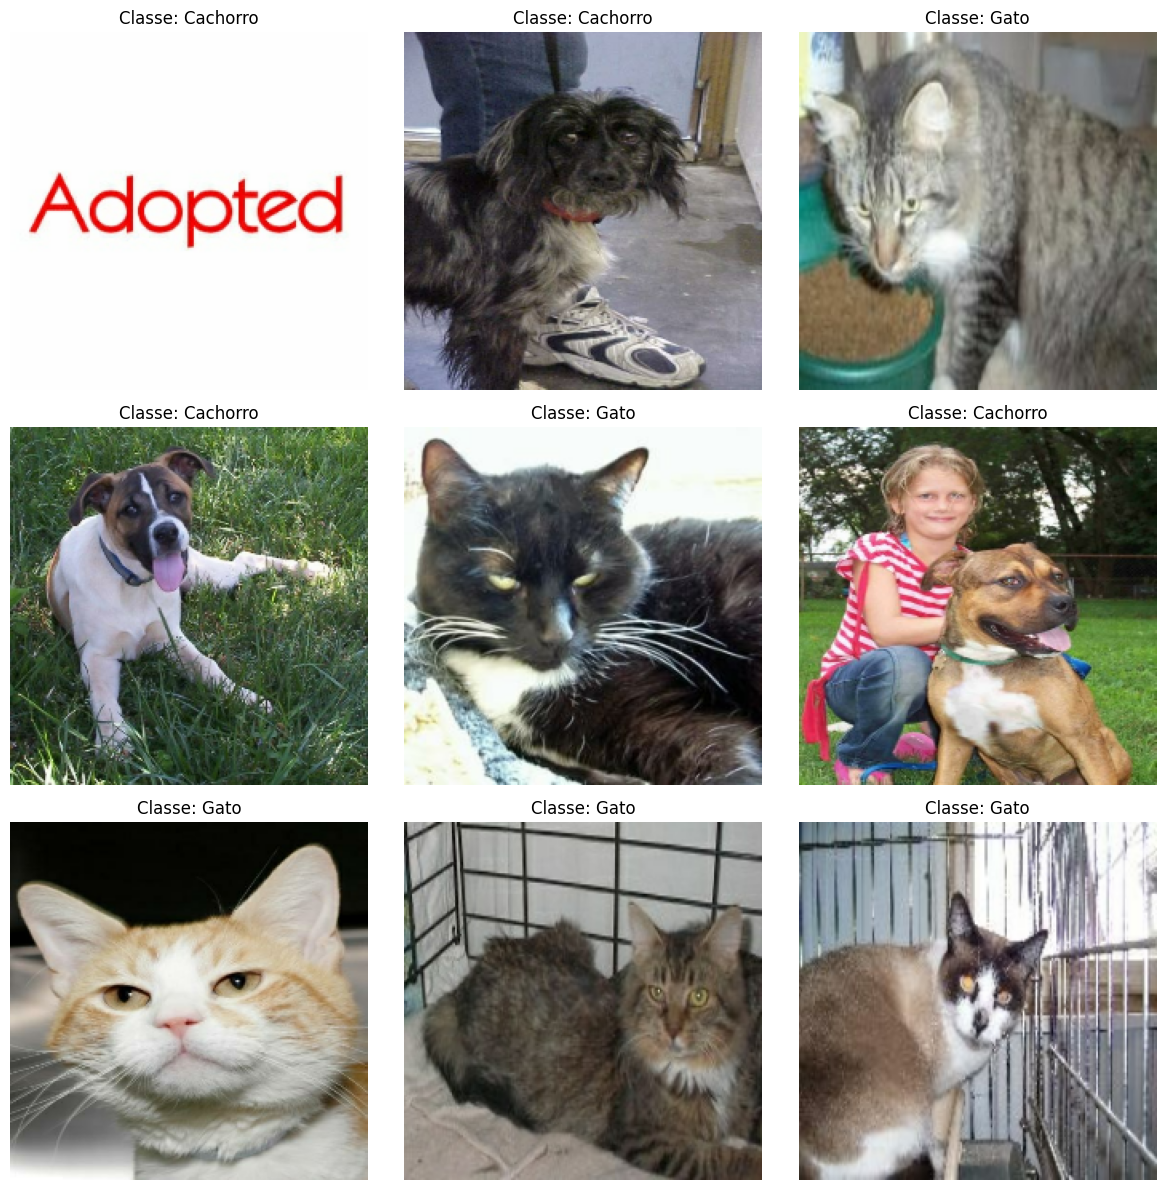

In [5]:
def plot_sample_images(dataset, num_images=9):
    plt.figure(figsize=(12, 12))
    class_names = ['Gato', 'Cachorro']

    for i, (image, label) in enumerate(dataset.unbatch().take(num_images)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy().astype('uint8'))
        plt.title(f'Classe: {class_names[label.numpy()]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Visualizando amostras do dataset:")
plot_sample_images(train_ds)

In [6]:
def create_transfer_learning_model():
    """
    Cria modelo usando Transfer Learning com VGG16
    """
    # Carrega o modelo VGG16 pré-treinado (sem as camadas densas finais)
    base_model = VGG16(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,  # Remove as camadas densas finais
        weights='imagenet'  # Usa pesos pré-treinados do ImageNet
    )

    # Congela as camadas do modelo base
    base_model.trainable = False

    # Cria o modelo completo
    model = models.Sequential([
        # Pré-processamento específico do VGG16
        layers.Lambda(lambda x: tf.keras.applications.vgg16.preprocess_input(x)),

        # Modelo base
        base_model,

        # Camadas personalizadas para classificação
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model, base_model

In [7]:
# Criação do modelo
model, base_model = create_transfer_learning_model()

# Compilação do modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Resumo do modelo
print("Arquitetura do modelo:")
model.summary()

print(f"\nNúmero de camadas do modelo base (VGG16): {len(base_model.layers)}")
print(f"Número de camadas treináveis: {len([l for l in model.layers if l.trainable])}")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Arquitetura do modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)


Número de camadas do modelo base (VGG16): 19
Número de camadas treináveis: 6


In [8]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'models/best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint]

In [ ]:
print("Iniciando treinamento (Feature Extraction)...")

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)

Iniciando treinamento (Feature Extraction)...
Epoch 1/20
 51/466 ━━━━━━━━━━━━━━━━━━━━ 2:12:56 19s/step - accuracy: 0.5227 - loss: 5.7677

In [ ]:
def fine_tune_model(model, base_model, fine_tune_at=100):
    """
    Aplica fine-tuning no modelo
    """
    # Descongela o modelo base
    base_model.trainable = True

    # Congela as camadas iniciais
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Recompila com learning rate menor
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE/10),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"Camadas treináveis após fine-tuning: {len([l for l in model.layers if l.trainable])}")

    return model

In [ ]:
print("\nAplicando Fine-tuning...")
model = fine_tune_model(model, base_model, fine_tune_at=15)

In [ ]:
history_fine = model.fit(
    train_ds,
    epochs=10,  # Menos épocas para fine-tuning
    initial_epoch=len(history.history['loss']),
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)

In [ ]:
def combine_histories(hist1, hist2):
    """Combina dois históricos de treinamento"""
    combined = {}
    for key in hist1.history.keys():
        combined[key] = hist1.history[key] + hist2.history[key]
    return combined

full_history = combine_histories(history, history_fine)

In [ ]:
def plot_training_history(history_dict):
    """
    Plota gráficos de loss e accuracy durante o treinamento
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot da acurácia
    axes[0].plot(history_dict['accuracy'], label='Treino')
    axes[0].plot(history_dict['val_accuracy'], label='Validação')
    axes[0].set_title('Acurácia do Modelo')
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Acurácia')
    axes[0].legend()
    axes[0].grid(True)

    # Plot da loss
    axes[1].plot(history_dict['loss'], label='Treino')
    axes[1].plot(history_dict['val_loss'], label='Validação')
    axes[1].set_title('Loss do Modelo')
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

print("Visualizando histórico de treinamento:")
plot_training_history(full_history)

In [ ]:
print("Avaliando modelo no conjunto de teste...")

# Avaliação no conjunto de teste
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"\nAcurácia no conjunto de teste: {test_accuracy:.4f}")
print(f"Loss no conjunto de teste: {test_loss:.4f}")

# Predições para matriz de confusão
y_pred = []
y_true = []

for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plota matriz de confusão
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusão')
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.show()

    return cm

class_names = ['Gato', 'Cachorro']
cm = plot_confusion_matrix(y_true, y_pred, class_names)

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
def predict_single_image(model, dataset, index=0):
    """
    Faz predição em uma única imagem
    """
    class_names = ['Gato', 'Cachorro']

    # Pega uma imagem do dataset de teste
    for i, (image, true_label) in enumerate(dataset.unbatch().take(index + 1)):
        if i == index:
            # Prepara a imagem para predição
            img_array = tf.expand_dims(image, 0)

            # Faz a predição
            predictions = model.predict(img_array, verbose=0)
            predicted_class = np.argmax(predictions[0])
            confidence = predictions[0][predicted_class]

            # Visualiza resultado
            plt.figure(figsize=(8, 6))
            plt.imshow(image.numpy().astype('uint8'))
            plt.title(f'Verdadeiro: {class_names[true_label.numpy()]}\n'
                     f'Predito: {class_names[predicted_class]} '
                     f'(Confiança: {confidence:.2f})')
            plt.axis('off')
            plt.show()

            break

print("Testando predições em imagens individuais:")
for i in range(3):
    predict_single_image(model, test_ds, index=i)

In [ ]:
# Salva o modelo final
model.save('models/cats_dogs_transfer_learning_final.h5')
print("Modelo salvo em 'models/cats_dogs_transfer_learning_final.h5'")

# Salva apenas os pesos
model.save_weights('models/cats_dogs_weights.h5')
print("Pesos salvos em 'models/cats_dogs_weights.h5'")

In [ ]:
print("\n" + "="*60)
print("RESUMO DOS RESULTADOS")
print("="*60)
print(f"Acurácia final no teste: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Loss final no teste: {test_loss:.4f}")
print(f"Épocas de treinamento: {len(full_history['loss'])}")
print(f"Melhor acurácia de validação: {max(full_history['val_accuracy']):.4f}")

# Estatísticas da matriz de confusão
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"\nMétricas para classe 'Cachorro':")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

print("\n" + "="*60)
print("PROJETO CONCLUÍDO COM SUCESSO!")
print("="*60)